In [1]:
# ==========================================
# 1. INSTALACJA BIBLIOTEK I IMPORTY
# ==========================================
!pip install trimesh matplotlib pandas scipy scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
import pandas as pd
import os

# Ustawienie urządzenia (GPU jeśli dostępne)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam urządzenia: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 48.1 MB/s eta 0:00:00
Używam urządzenia: cuda


In [2]:
# ==========================================
# 2. PRZYGOTOWANIE DANYCH
# ==========================================

class PointCloudDataset:
    def __init__(self, mesh_path, num_samples=2048, normalize_rotation=True):
        self.num_samples = num_samples
        self.normalize_rotation = normalize_rotation

        if os.path.exists(mesh_path):
            print(f"Ładowanie pliku: {mesh_path}")
            mesh = trimesh.load(mesh_path)
            if isinstance(mesh, trimesh.Scene):
                mesh = trimesh.util.concatenate(mesh.dump())
            self.points = mesh.sample(num_samples)
        else:
            print(f"Plik {mesh_path} nie istnieje.")

        self.process_geometry()

    def process_geometry(self):
        #  Centrowanie
        self.points = self.points - np.mean(self.points, axis=0)

        # PCA
        if self.normalize_rotation:
            pca = PCA(n_components=3)
            self.points = pca.fit_transform(self.points)

            for i in range(3):
                if np.max(self.points[:, i]) < -np.min(self.points[:, i]):
                    self.points[:, i] *= -1

        # Skalowanie
        max_dist = np.max(np.linalg.norm(self.points, axis=1))
        self.points = self.points / max_dist

    def get_tensor(self):
        return torch.from_numpy(self.points).float().to(device)

In [3]:
# ==========================================
# 3. ARCHITEKTURA (MLP + POSITIONAL ENCODING)
# ==========================================

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs=10):
        super().__init__()
        self.freqs = 2 ** torch.arange(num_freqs).float().to(device) * torch.pi

    def forward(self, x):
        # x: [Batch, 3]
        # output: [Batch, 3 + 3 * 2 * num_freqs]
        embed = [x]
        for freq in self.freqs:
            embed.append(torch.sin(x * freq))
            embed.append(torch.cos(x * freq))
        return torch.cat(embed, dim=-1)

class DeformationField(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_freqs=10):
        super().__init__()
        self.pe = PositionalEncoding(num_freqs)
        input_size = input_dim + input_dim * 2 * num_freqs # 3 + 60 = 63

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3) # Wyjście: wektor przesunięcia (dx, dy, dz)
        )

    def forward(self, x):
        x_encoded = self.pe(x)
        displacement = self.net(x_encoded)
        return displacement

In [9]:
# ==========================================
# ARCHITEKTURA v2 (SKIP CONNECTIONS + INIT)
# ==========================================

class DeformationFieldPro(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, num_freqs=10, skip_layer=4):
        super().__init__()
        self.pe = PositionalEncoding(num_freqs)
        self.input_size = input_dim + input_dim * 2 * num_freqs
        self.skip_layer = skip_layer

        layers = []
        for _ in range(skip_layer):
            layers.append(nn.Linear(self.input_size if _ == 0 else hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.Softplus(beta=100))
        self.layers_enc = nn.Sequential(*layers)

        layers_dec = []
        for i in range(4):
            in_dim = (hidden_dim + self.input_size) if i == 0 else hidden_dim
            layers_dec.append(nn.Linear(in_dim, hidden_dim))
            layers_dec.append(nn.LayerNorm(hidden_dim))
            layers_dec.append(nn.Softplus(beta=100))
        self.layers_dec = nn.Sequential(*layers_dec)

        self.last_layer = nn.Linear(hidden_dim, 3)
        nn.init.normal_(self.last_layer.weight, mean=0.0, std=1e-5)
        nn.init.constant_(self.last_layer.bias, 0.0)

    def forward(self, x):
        x_encoded = self.pe(x)

        h = self.layers_enc(x_encoded)
        h = torch.cat([h, x_encoded], dim=-1)
        h = self.layers_dec(h)

        displacement = self.last_layer(h)
        return displacement

# ==========================================
# TRENING Z COSINE ANNEALING
# ==========================================

def train_model_pro(model_name, source_path, target_points_tensor, epochs=600):
    print(f"\n--- Rozpoczynam trening PRO: {model_name} ---")

    dataset = PointCloudDataset(source_path)
    source_points = dataset.get_tensor()

    model = DeformationFieldPro(hidden_dim=256).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    loss_history = []

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        displacement = model(source_points)
        deformed_points = source_points + displacement

        loss_cd = chamfer_distance(deformed_points, target_points_tensor)

        loss_reg = torch.mean(displacement**2)

        loss = loss_cd * 1000 + loss_reg * 1.0

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        loss_history.append(loss_cd.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss Total {loss.item():.4f} | CD: {loss_cd.item():.6f}")

    return model, source_points, loss_history

In [14]:
# ==========================================
# 4. FUNKCJE STRATY I METRYKI
# ==========================================

def chamfer_distance(p1, p2):
    """
    L_chamfer = mean(min(p1->p2)) + mean(min(p2->p1))
    """
    # p1: [N, 3], p2: [M, 3]
    dist = torch.cdist(p1.unsqueeze(0), p2.unsqueeze(0)).squeeze(0) # [N, M]

    min_dist_p1, _ = torch.min(dist, dim=1)
    min_dist_p2, _ = torch.min(dist, dim=0)

    return torch.mean(min_dist_p1**2) + torch.mean(min_dist_p2**2)

def voxelize(points, resolution=32):
    voxel_grid = np.zeros((resolution, resolution, resolution), dtype=bool)

    # Przeskalowanie punktów [-1, 1] -> [0, resolution-1]
    norm_points = (points + 1.0) * 0.5 * (resolution - 1)
    norm_points = norm_points.astype(int)

    mask = (norm_points[:, 0] >= 0) & (norm_points[:, 0] < resolution) & \
           (norm_points[:, 1] >= 0) & (norm_points[:, 1] < resolution) & \
           (norm_points[:, 2] >= 0) & (norm_points[:, 2] < resolution)
    norm_points = norm_points[mask]

    voxel_grid[norm_points[:, 0], norm_points[:, 1], norm_points[:, 2]] = True
    return voxel_grid

def calculate_iou_dice(pred_points, target_points, res=32):
    v_pred = voxelize(pred_points.detach().cpu().numpy(), res)
    v_target = voxelize(target_points.detach().cpu().numpy(), res)

    intersection = np.logical_and(v_pred, v_target).sum()
    union = np.logical_or(v_pred, v_target).sum()
    sum_volumes = v_pred.sum() + v_target.sum()

    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / sum_volumes if sum_volumes > 0 else 0

    return iou, dice

In [17]:
# ==========================================
# 6. WIZUALIZACJA
# ==========================================

def visualize_morphing(model, source_points, title="Morphing"):
    model.eval()
    with torch.no_grad():
        final_displacement = model(source_points)

    steps = [0.0, 0.3, 0.6, 1.0] # t=0 (start), t=0.5 (środek), t=1.0 (koniec)
    fig = plt.figure(figsize=(15, 5))

    for i, t in enumerate(steps):
        ax = fig.add_subplot(1, 4, i+1, projection='3d')

        # Interpolacja liniowa pozycji
        current_points = source_points + final_displacement * t
        p = current_points.cpu().numpy()

        ax.scatter(p[:,0], p[:,1], p[:,2], s=1, c=p[:,2], cmap='viridis')
        ax.set_title(f"{title} (t={t})")
        ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
        ax.axis('off')

    plt.show()

def save_reconstructed_mesh(points, filename):
    if torch.is_tensor(points):
        pts = points.detach().cpu().numpy()
    else:
        pts = points

    cloud = trimesh.points.PointCloud(pts)
    cloud.export(filename)
    print(f"Model zapisany jako: {filename}")

Przygotowanie obiektu czajnika...
Ładowanie pliku: teapot.obj

--- Rozpoczynam trening PRO: bunny-flow ---
Ładowanie pliku: bunny.obj
Epoch 0: Loss Total 21.3406 | CD: 0.021341
Epoch 100: Loss Total 1.5875 | CD: 0.001572
Epoch 200: Loss Total 0.7680 | CD: 0.000756
Epoch 300: Loss Total 0.6543 | CD: 0.000642
Epoch 400: Loss Total 0.1444 | CD: 0.000132
Epoch 500: Loss Total 0.1288 | CD: 0.000117


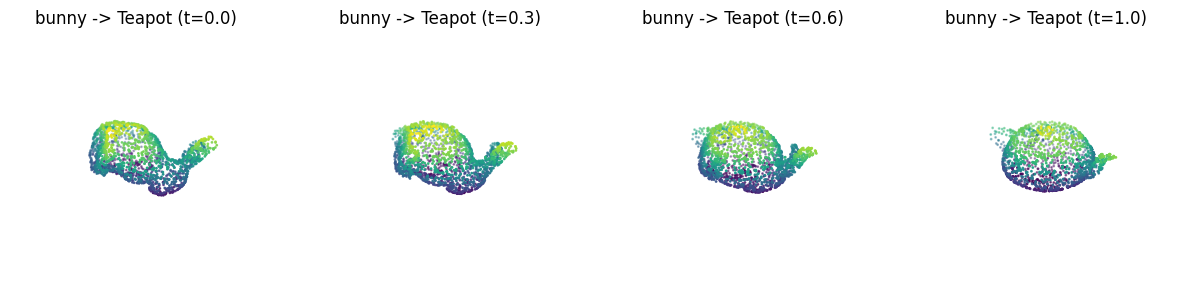

Model zapisany jako: result_bunny_to_teapot.obj

--- Rozpoczynam trening PRO: dragon-flow ---
Ładowanie pliku: dragon.obj
Epoch 0: Loss Total 44.0504 | CD: 0.044050
Epoch 100: Loss Total 1.4629 | CD: 0.001442
Epoch 200: Loss Total 0.4408 | CD: 0.000422
Epoch 300: Loss Total 0.4751 | CD: 0.000456
Epoch 400: Loss Total 0.1766 | CD: 0.000158
Epoch 500: Loss Total 0.1293 | CD: 0.000110


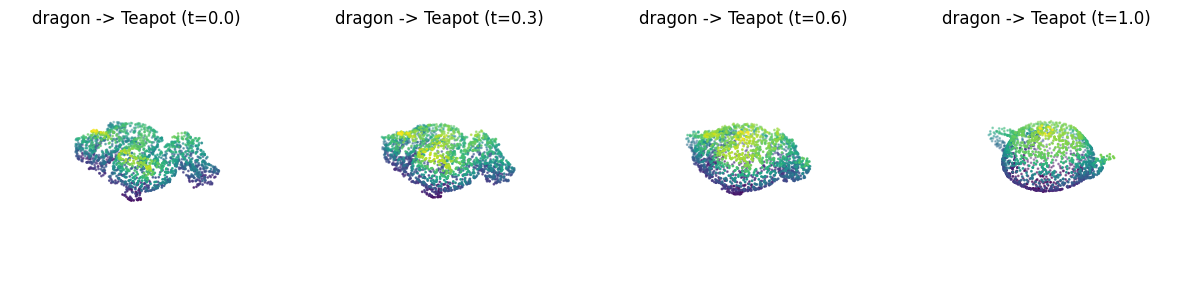

Model zapisany jako: result_dragon_to_teapot.obj

--- Rozpoczynam trening PRO: armadillo-flow ---
Ładowanie pliku: armadillo.obj
Epoch 0: Loss Total 51.9794 | CD: 0.051979
Epoch 100: Loss Total 1.2746 | CD: 0.001251
Epoch 200: Loss Total 0.6975 | CD: 0.000674
Epoch 300: Loss Total 0.4477 | CD: 0.000424
Epoch 400: Loss Total 0.2234 | CD: 0.000199
Epoch 500: Loss Total 0.1463 | CD: 0.000122


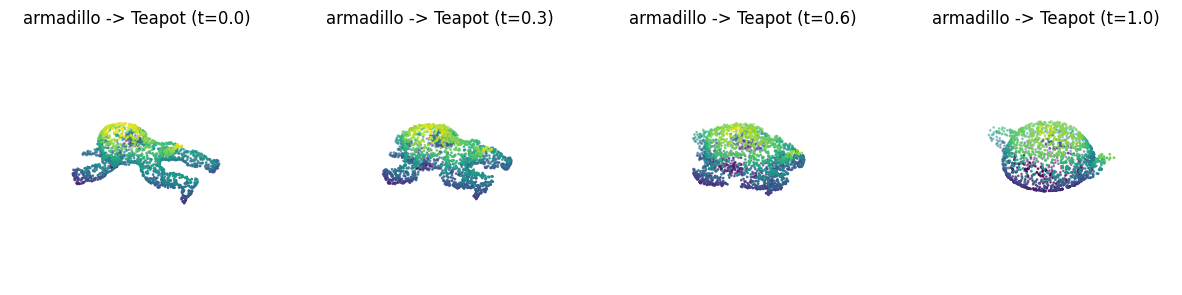

Model zapisany jako: result_armadillo_to_teapot.obj

--- Testowanie generalizacji na Asian Dragon ---
Ładowanie pliku: asian_dragon_small.obj
Model zapisany jako: result_asian_dragon_via_bunny.obj


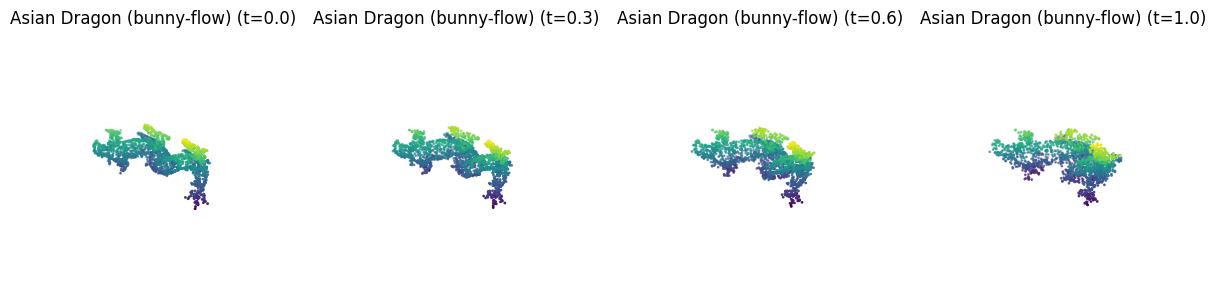

Model zapisany jako: result_asian_dragon_via_dragon.obj


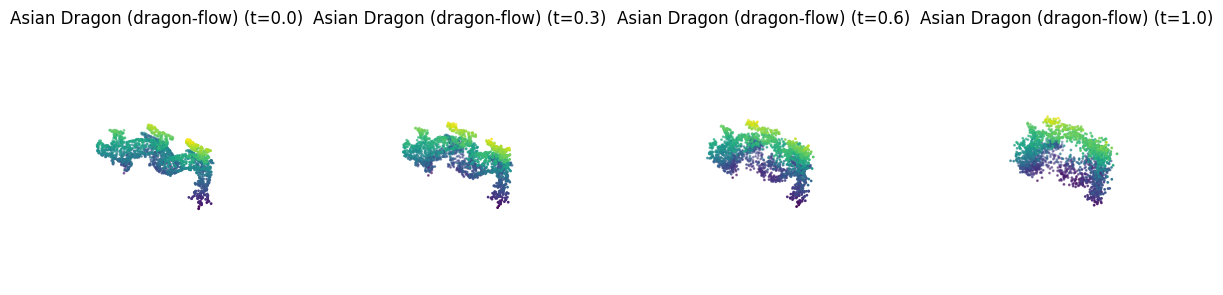

Model zapisany jako: result_asian_dragon_via_armadillo.obj


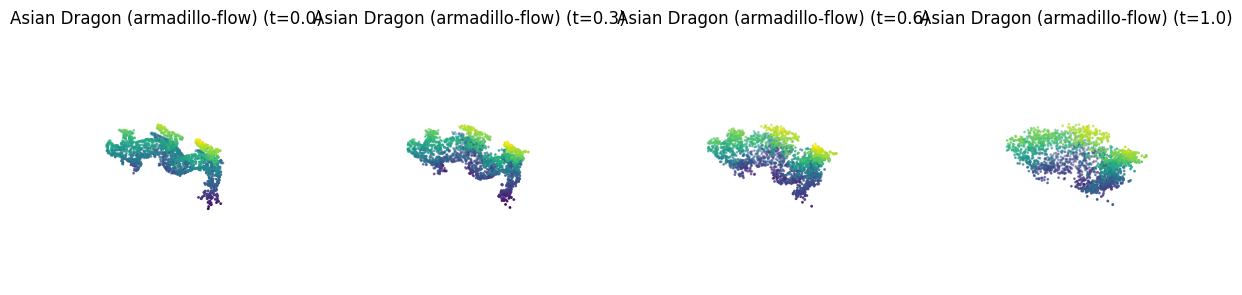

In [18]:
# ==========================================
# 7. main
# ==========================================

files = {
    'bunny': 'bunny.obj',
    'dragon': 'dragon.obj',
    'armadillo': 'armadillo.obj',
    'asian_dragon': 'asian_dragon_small.obj',
    'teapot': 'teapot.obj'
}

print("Przygotowanie obiektu czajnika...")
target_dataset = PointCloudDataset(files['teapot'])
target_points_tensor = target_dataset.get_tensor()

models = {}
results = []

train_objects = ['bunny', 'dragon', 'armadillo']

for obj_name in train_objects:
    model, src_pts, _ = train_model_pro(f"{obj_name}-flow", files[obj_name], target_points_tensor)
    models[obj_name] = model

    visualize_morphing(model, src_pts, title=f"{obj_name} -> Teapot")

    with torch.no_grad():
        deformed = src_pts + model(src_pts)

        output_fn = f"result_{obj_name}_to_teapot.obj"
        save_reconstructed_mesh(deformed, output_fn)

        cd_val = chamfer_distance(deformed, target_points_tensor).item()
        iou_val, dice_val = calculate_iou_dice(deformed, target_points_tensor)

        results.append({
            "Metoda": f"{obj_name}-flow",
            "Obiekt testowy": obj_name, # Testujemy na tym samym na czym trenowaliśmy
            "Chamfer": cd_val,
            "IoU": iou_val,
            "Dice": dice_val
        })

print("\n--- Testowanie generalizacji na Asian Dragon ---")
asian_dragon_dataset = PointCloudDataset(files['asian_dragon'])
asian_pts = asian_dragon_dataset.get_tensor()

for obj_name in train_objects:
    model = models[obj_name]
    model.eval()

    with torch.no_grad():
        deformed_asian = asian_pts + model(asian_pts)

        output_fn_asian = f"result_asian_dragon_via_{obj_name}.obj"
        save_reconstructed_mesh(deformed_asian, output_fn_asian)

        cd_val = chamfer_distance(deformed_asian, target_points_tensor).item()
        iou_val, dice_val = calculate_iou_dice(deformed_asian, target_points_tensor)

        results.append({
            "Metoda": f"{obj_name}-flow",
            "Obiekt testowy": "Asian Dragon",
            "Chamfer": cd_val,
            "IoU": iou_val,
            "Dice": dice_val
        })

    visualize_morphing(model, asian_pts, title=f"Asian Dragon ({obj_name}-flow)")

In [19]:
# ==========================================
# 8. WYNIKI
# ==========================================
print("\n=== TABELA WYNIKÓW ===")
df_results = pd.DataFrame(results)
display(df_results)
df_results.to_csv("wyniki_projektu.csv", index=False)


=== TABELA WYNIKÓW ===


,Metoda,Obiekt testowy,Chamfer,IoU,Dice
0,bunny-flow,bunny,0.000111,0.900979,0.947911
1,dragon-flow,dragon,0.000106,0.895311,0.944764
2,armadillo-flow,armadillo,0.000113,0.881650,0.937103
3,bunny-flow,Asian Dragon,0.041678,0.097919,0.178372
4,dragon-flow,Asian Dragon,0.029329,0.162179,0.279095
5,armadillo-flow,Asian Dragon,0.021598,0.184163,0.311044
